### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, GRU, Dense, TimeDistributed, RepeatVector, Multiply, Permute, Flatten
from keras.callbacks import EarlyStopping

from pythermalcomfort.models import pmv_ppd
from pythermalcomfort.utilities import v_relative, clo_dynamic, met_typical_tasks, clo_individual_garments

from air_conditioner import AirConditioner

#AC modelling
ac = AirConditioner()

### Loading And Preprocessing Dataset For Training

In [11]:
df = pd.read_csv('dataset/Test_Day1.csv')
# df = pd.read_csv('dataset/Test_Day2.csv')
# df = pd.read_csv('dataset/Test_Day3.csv')
# df = pd.read_csv('dataset/Test_Day4.csv')
# df = pd.read_csv('dataset/Test_Day5.csv')
df

,timestamp,t_room,rh_room,t_out,rh_out,setpoint
0,7/1/2024 0:00,24.166667,43,31.75,78,23
1,7/1/2024 0:01,24.000000,43,31.75,78,23
2,7/1/2024 0:02,23.833333,42,31.75,78,23
3,7/1/2024 0:03,23.666667,42,31.75,78,23
4,7/1/2024 0:04,24.000000,42,31.75,78,23
...,...,...,...,...,...,...
1435,7/1/2024 23:55,22.833333,44,31.80,65,22
1436,7/1/2024 23:56,23.000000,44,31.80,65,22
1437,7/1/2024 23:57,22.833333,44,31.80,65,22
1438,7/1/2024 23:58,22.666667,44,31.80,65,22


In [12]:
## Calculating Specific humidity from relative humidity

def calculate_specific_humidity(T, RH, P_atm = 101.325):
    RH = RH/100
    P_sat = 0.61078 * np.exp(17.27*T/(T+237.3))
    w = 0.622 * (RH * P_sat)/(P_atm - RH*P_sat)
    return w


for i in range(df.shape[0]):
    RH_indoor = df.loc[i, "rh_room"]
    RH_outdoor = df.loc[i, "rh_out"]
    T_indoor = df.loc[i, "t_room"]
    T_outdoor = df.loc[i, "t_out"]
    w1 = calculate_specific_humidity(T_indoor, RH_indoor)
    w2 = calculate_specific_humidity(T_outdoor, RH_outdoor)
    df.loc[i, 'h_room'] = w1
    df.loc[i, 'h_out'] = w2

In [13]:
# Calculating Offsets

df['t_offset'] = df['t_out'] - df['t_room']
df['tsp_offset'] = df['t_out'] - df['setpoint']
df['h_offset'] = df['h_out']- df['h_room']

In [14]:
# calculating energy

for i in range(df.shape[0]):
    T_indoor= df.loc[i,'t_room']
    T_outdoor = df.loc[i, 't_out']
    RH_indoor = df.loc[i, 'rh_room']
    RH_outdoor = df.loc[i, 'rh_out']
    T_setpoint = df.loc[i,'setpoint']
    energy= ac.calculate_energy_consumption(T_indoor, T_outdoor, RH_indoor, RH_outdoor, T_setpoint)
    df.loc[i, 'energy'] = energy


### Machine Learning Setup

In [15]:
# selecting features to predict energy
features = ['h_offset', 't_offset', 'tsp_offset', 'energy']

# loading scalar for normalizing the input before sending into ML model
with open('checkpoints/scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)
with open('checkpoints/scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# Constants
sequence_length = 10
delay = 10

In [16]:
from model_definition import *
model_name = "lstm_attention"
input_shape = (sequence_length, len(features))

model_map = {
    "cnn": build_cnn_model,
    "lstm": build_lstm_model,
    "gru": build_gru_model,
    "bilstm": build_bilstm_model,
    "bigru": build_bigru_model,
    "cnn_lstm": build_cnn_lstm_model,
    "cnn_gru": build_cnn_gru_model,
    "lstm_attention": build_lstm_attention_model,
    "gru_attention": build_gru_attention_model
}

# define model architecture
model = model_map[model_name](input_shape) 

# Loading model from checkpoint
checkpoint_path = "checkpoints/"+ model_name + "10.h5"
model = tf.keras.models.load_model(checkpoint_path)

In [17]:
def predict_energy(X_, y_):
    # Normalizing
    X_ = scaler_X.transform(X_)
    y_ = scaler_y.transform(y_)

    # Predicting
    X_ = np.expand_dims(X_, 0)
    # E_pred = model.predict(X_)
    E_pred = model(X_).numpy()
    
    # Inverse Normalization
    E_pred = scaler_y.inverse_transform(E_pred).squeeze()
    E_real = scaler_y.inverse_transform(y_).squeeze()

    return E_pred, E_real

In [18]:
for t in range(sequence_length, df.shape[0]- delay):
    X_ = df.loc[t-sequence_length:t-1, features].values
    y_ = df.loc[t+delay, 'energy'].reshape(-1, 1)

    E_pred, _ = predict_energy(X_, y_)
    df.loc[t+delay, 'predicted_energy'] = E_pred

<Axes: >

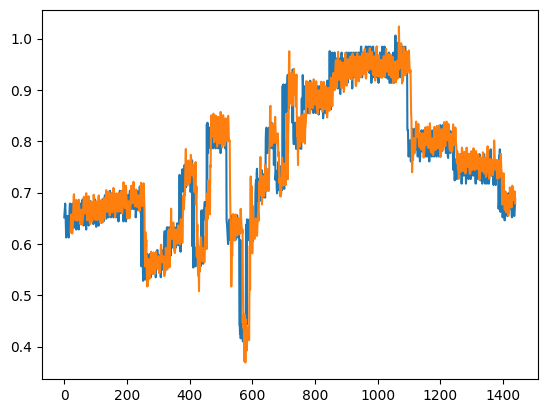

In [19]:
df['energy'].plot()
df['predicted_energy'].plot()

### Running Simulation on Test Day

In [21]:
## Simulation Constant


v = 0.5  # average air speed, [m/s]
activity = "Typing"  # participant's activity description
met = met_typical_tasks[activity]  # activity met, [met]
vr = v_relative(v=v, met=met) # calculate the relative air velocity

# calculate total clothing insulation
garments = ["Sweatpants", "T-shirt", "Shoes or sandals"]
icl = sum(
    [clo_individual_garments[item] for item in garments]
)
icl = 0.7
clo = clo_dynamic(clo=icl, met=met)

min_pmv = -0.1
max_pmv = 0.1
setpoint_offset = 0.1
system_interval = 10 # runs at every 10 minutes
runtime = 1440 # minutes (full day)

In [22]:
# sensor input
room_temperature_database = df[:sequence_length+1]['t_room'].values
room_humidity_database = df['rh_room'].values
outdoor_temperature_database = df['t_out'].values
outdoor_humidity_database = df['rh_out'].values
setpoint_database = df[:sequence_length+1]['setpoint'].values

for t in range(sequence_length, runtime, system_interval):
    # sensor input
    room_temperature = room_temperature_database[t]
    room_humidity = room_humidity_database[t]
    outdoor_temperature = outdoor_temperature_database[t]
    outdoor_humidity = outdoor_humidity_database[t]

    tr = room_temperature + 2
    results = pmv_ppd(tdb=room_temperature, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs=False )
    pmv = results['pmv']
    
    # if room temperature is within comfort zone, Select setpoint that achieves maximum acceptable pmv score
    setpoint = room_temperature
    if min_pmv <= pmv <= max_pmv:
        while min_pmv <= pmv <= max_pmv:
            setpoint = setpoint + setpoint_offset
            tr = setpoint + 2
            results = pmv_ppd(tdb=setpoint, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs=False)
            pmv = results['pmv']
        
        setpoint = setpoint-setpoint_offset
    
    # if room temperature is outside of comfort zone
    else:
        # if pmv is positive, reduce temperature for comfort
        if pmv > 0:
            while pmv >= max_pmv:
                setpoint = setpoint -setpoint_offset
                tr = setpoint + 2
                results = pmv_ppd(tdb=setpoint, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs= False)
                pmv = results['pmv']
        
        # if pmv is negative, increase temperature for comfort
        else:
            while pmv <= min_pmv:
                setpoint = setpoint + setpoint_offset
                tr = setpoint + 2
                results = pmv_ppd(tdb=setpoint, tr=tr, vr=vr, rh=room_humidity, met=met, clo=clo, standard="ASHRAE", limit_inputs= False)
                pmv = results['pmv']

    setpoint = np.round(setpoint)    
    # Simulate room temperature and add them to room temperature database which can be used for next inputs
    T_i = room_temperature
    for i in range(system_interval):
        T_o = outdoor_temperature_database[t+i]
        rh_i = room_humidity_database[t+i]
        rh_o = outdoor_humidity_database[t+i]

        if (T_i - setpoint) > 2:
            heat_gain = ac.calculate_total_heat_gain(T_indoor=T_i, T_outdoor=T_o, RH_indoor=rh_i, RH_outdoor=rh_o)
            T_i = ac.calculate_room_temperature_after_cooling(heat_gain, T_i, 60)
        elif setpoint > T_i:
            heat_gain = ac.calculate_total_heat_gain(T_indoor=T_i, T_outdoor=T_o, RH_indoor=rh_i, RH_outdoor=rh_o)
            T_i = ac.calculate_room_temperature_when_standby(heat_gain, T_i, 60)
        else:
            pass

        room_temperature_database = np.append(room_temperature_database, T_i)
        setpoint_database = np.append(setpoint_database, setpoint)
        print('timestep : ',t+i, ' PMV : ',pmv, 'Setpoint : ',setpoint, 'Room Temp : ', T_i)
   
room_temperature_database = room_temperature_database[:-1]
setpoint_database = setpoint_database[:-1]

timestep :  10  PMV :  -0.08 Setpoint :  25.0 Room Temp :  24.79607095920897
timestep :  11  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  12  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  13  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  14  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  15  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  16  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  17  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  18  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  19  PMV :  -0.08 Setpoint :  25.0 Room Temp :  25.407751677950326
timestep :  20  PMV :  0.11 Setpoint :  26.0 Room Temp :  26.002077960542504
timestep :  21  PMV :  0.11 Setpoint :  26.0 Room Temp :  26.002077960542504
timestep :  22  PMV :  0.11 Setpoint :  26.0 Room Temp :  26.002077

In [23]:
system_running_records = pd.DataFrame()
system_running_records['t_room'] = room_temperature_database
system_running_records['t_out'] = outdoor_temperature_database
system_running_records['rh_room'] = room_humidity_database
system_running_records['rh_out'] = outdoor_humidity_database
system_running_records['setpoint'] = setpoint_database
system_running_records['t_offset'] = system_running_records['t_out']-system_running_records['t_room']
system_running_records['tsp_offset'] = system_running_records['t_out']-system_running_records['setpoint']

H_indoor = []
H_outdoor = []
for i in range(system_running_records.shape[0]):
    RH_indoor = system_running_records.loc[i, "rh_room"]
    RH_outdoor = system_running_records.loc[i, "rh_out"]
    T_indoor = system_running_records.loc[i, "t_room"]
    T_outdoor = system_running_records.loc[i, "t_out"]
    w1 = calculate_specific_humidity(T_indoor, RH_indoor)
    w2 = calculate_specific_humidity(T_outdoor, RH_outdoor)
    H_indoor.append(w1)
    H_outdoor.append(w2)

system_running_records["h_room"] = H_indoor
system_running_records["h_out"] = H_outdoor
system_running_records['h_offset'] = system_running_records['h_out'] - system_running_records['h_room']


In [25]:
# We can either set the initial energy to 0 
# system_running_records['energy'] = 0.0

# Or calculate the initial energy through AC model
for i in range(sequence_length+delay+1):
    T_indoor= system_running_records.loc[i,'t_room']
    T_outdoor = system_running_records.loc[i, 't_out']
    RH_indoor = system_running_records.loc[i, 'rh_room']
    RH_outdoor = system_running_records.loc[i, 'rh_out']
    T_setpoint = system_running_records.loc[i,'setpoint']
    energy= ac.calculate_energy_consumption(T_indoor, T_outdoor, RH_indoor, RH_outdoor, T_setpoint)
    system_running_records.loc[i, 'energy'] = energy

system_running_records

for t in range(sequence_length, len(system_running_records)-delay-1):
    
    # Taking past 'sequence length' timesteps as input to predict current energy
    X_ = system_running_records.loc[t-sequence_length:t-1, features].values
    y_ = system_running_records.loc[t+delay+1, 'energy'].reshape(-1, 1)
    
    # Predicting predicted and real current value in Amps
    E_pred, _ = predict_energy(X_, y_)
    # Store the new prediction to the dataframe and repeat
    system_running_records.loc[t+delay+1, 'energy'] = E_pred


system_running_records['saved_energy'] = df['energy'] - system_running_records['energy']

In [14]:
# Saving the output
# system_running_records.to_csv('output/user_vs_system_day3.csv', index=False)

In [5]:
df_1 = pd.read_csv('output/user_vs_system_day1.csv')
df_2 = pd.read_csv('output/user_vs_system_day2.csv')
df_3 = pd.read_csv('output/user_vs_system_day3.csv')
df_5 = pd.read_csv('output/user_vs_system_day5.csv')

In [20]:
day_1 = (df_1['saved_energy']/df_1['energy']).values
day_2 = (df_2['saved_energy']/df_2['energy']).values
day_3 = (df_3['saved_energy']/df_3['energy']).values
day_5 = (df_5['saved_energy']/df_5['energy']).values

In [21]:
print("Day 1 mean : ", day_1.mean())
print("Day 2 mean : ", day_2.mean())
print("Day 3 mean : ", day_3.mean())
print("Day 5 mean : ", day_5.mean())
print("All day mean: ", (day_1.mean() + day_2.mean()+ day_3.mean() + day_5.mean())/4)      


Day 1 mean :  0.2096278244219852
Day 2 mean :  0.2866401151068186
Day 3 mean :  0.1290870031619986
Day 5 mean :  0.13919278321402354
All day mean:  0.19113693147620647


In [18]:
day_1

array([0.        , 0.        , 0.        , ..., 0.2351536 , 0.2515439 ,
       0.28349398])

<Axes: >

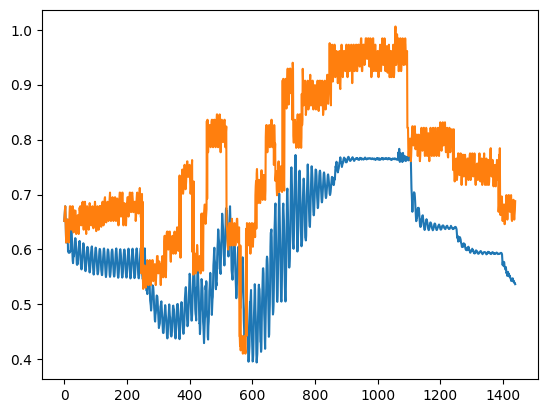

In [30]:
system_running_records['energy'].plot()
df['energy'].plot()

<Axes: >

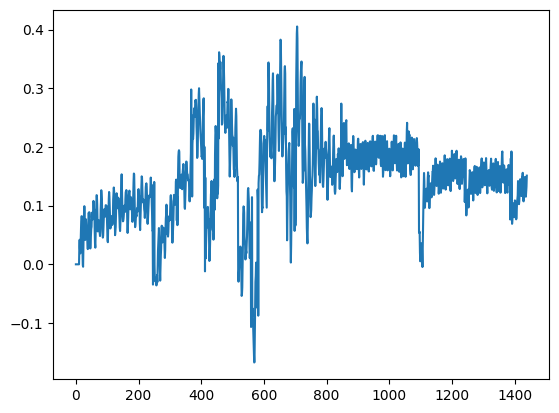

In [29]:
system_running_records['saved_energy'].plot()
